In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# New section

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-03-19 11:58:54.938445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 11:58:55.372968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/junwoo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TIME_INTERVAL = 1
NB_INPUT_FEATURES = 3
NB_LABEL_FEATURES = 1
WINDOW_WIDTH=10
SHUFFLE=True
MAX_EPOCHS = 10000
BATCH_SIZE=256
PATIENCE=250

In [3]:
N=1
T=10000
L = 1.5*128

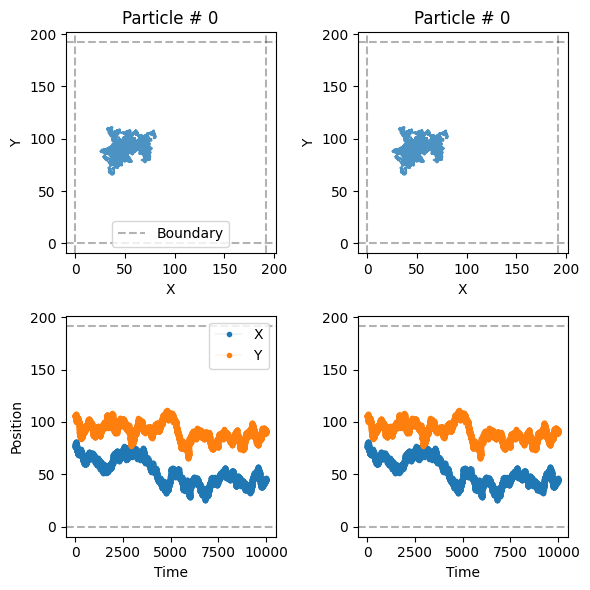

In [4]:
trajs_model, labels_model = models_phenom().multi_state(N=N,
                                                        L=L,
                                                        T=T,
                                                        alphas=[0.85, 1.15],  # Fixed alpha for each state
                                                        Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                        M=[[0.95, 0.05], [0.05, 0.95]]
                                                       )
plot_trajs(trajs_model, L, N, num_to_plot =2)

In [5]:
changepoints, alphas, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
print(f'change points: {changepoints}, {changepoints.shape}')
print(f'alphas: {alphas}, {alphas.shape}')
print(f'Ds: {Ds}, {Ds.shape}')
print(f'State_nums: {state_num}, {state_num.shape}')

weight_for_0 = (1 / (T-len(changepoints))) * (T / 2.0)
weight_for_1 = (1 / len(changepoints) * (T / 2.0))
CLASS_WEIGHT = {0: weight_for_0, 1: weight_for_1}
print(CLASS_WEIGHT)

change points: [   40    44    57    60    93   106   123   160   255   331   335   336
   338   345   402   444   450   479   485   507   514   541   597   637
   650   673   687   716   753   772   775   784   817   869   890   894
   920   924   958   976  1064  1077  1135  1187  1201  1225  1226  1244
  1260  1271  1286  1290  1295  1314  1376  1385  1409  1423  1433  1446
  1507  1524  1533  1562  1575  1578  1580  1684  1686  1699  1739  1801
  1803  1838  1839  1844  1854  1860  1924  1941  1945  1960  1972  2001
  2024  2037  2070  2183  2205  2207  2228  2237  2268  2298  2302  2346
  2358  2406  2424  2442  2444  2474  2489  2495  2499  2515  2518  2533
  2548  2582  2585  2596  2600  2603  2622  2648  2654  2658  2665  2681
  2683  2715  2812  2848  2853  2857  2882  2898  2925  2956  2960  2995
  3000  3008  3019  3024  3052  3063  3064  3092  3112  3125  3135  3143
  3152  3160  3212  3224  3225  3231  3237  3257  3259  3280  3311  3314
  3318  3323  3332  3333  3371  3377

In [6]:
xs = trajs_model[:, 0, 0]
ys = trajs_model[:, 0, 1]
pos = np.array([xs, ys]).T
trajectory_object = TrajectoryObj(index=0)
for t, (x, y) in enumerate(pos):
    trajectory_object.add_trajectory_position(t, x, y, 0.0)
label_list = read_andi2_trajectory_label([Ds, alphas, state_num, changepoints])
trajectory_label = label_list[0]

print(xs[:10])
print(ys[:10])

[75.98665111 76.05855503 75.73781357 76.61224784 76.53502367 76.70662616
 77.19682109 76.66651479 76.6784826  77.74940738]
[105.98157951 105.75081405 105.56523782 105.23161559 105.66754203
 105.89308643 105.64990296 105.21964455 105.7448121  105.64867583]


In [7]:
"""
trajectory_list = read_trajectory(f'data/trajs_fov_0.csv')
label_list = read_andi2_trajectory_label(f'data/traj_labs_fov_0.txt')
trajectory_object = trajectory_list[0]
trajectory_label = label_list[0]
"""

"\ntrajectory_list = read_trajectory(f'data/trajs_fov_0.csv')\nlabel_list = read_andi2_trajectory_label(f'data/traj_labs_fov_0.txt')\ntrajectory_object = trajectory_list[0]\ntrajectory_label = label_list[0]\n"

In [8]:
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)
xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3].astype(int)

In [9]:
print(msd.shape, diff_coefs.shape, angles.shape, xs.shape, ys.shape, labeled_diff_coefs.shape, labeled_alphas.shape, labeled_states.shape, labeled_cps.shape)

(10000,) (10000,) (10000,) (10000,) (10000,) (10000,) (10000,) (10000,) (10000,)


In [10]:
#df = np.array([xs, ys, diff_coefs, msd, angles]).T
df = np.array([diff_coefs, msd, angles]).T
#df = pd.DataFrame(df, columns=['xs', 'ys', 'diff_coefs', 'msd', 'angles'])
df = pd.DataFrame(df, columns=['diff_coefs', 'msd', 'angles'])
target_df = np.array([labeled_cps]).T  # labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps
target_df = pd.DataFrame(target_df, columns=['cps'])  # 'lb_diff_coefs', 'alphas', 'states', 'cps'

In [11]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

target_train_df = target_df[0:int(n*0.7)]
target_val_df = target_df[int(n*0.7):int(n*0.9)]
target_test_df = target_df[int(n*0.9):]

In [12]:
"""
train_mean = train_df.mean()
train_std = train_df.std()

for normallization_col in ['xs', 'ys']:
    train_df[normallization_col] = (train_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    val_df[normallization_col] = (val_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]
    test_df[normallization_col] = (test_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

print(train_df.head())
"""

"\ntrain_mean = train_df.mean()\ntrain_std = train_df.std()\n\nfor normallization_col in ['xs', 'ys']:\n    train_df[normallization_col] = (train_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n    val_df[normallization_col] = (val_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n    test_df[normallization_col] = (test_df[normallization_col] - train_mean[normallization_col]) / train_std[normallization_col]\n\ndf_std = (df - train_mean) / train_std\ndf_std = df_std.melt(var_name='Column', value_name='Normalized')\nplt.figure(figsize=(12, 6))\nax = sns.violinplot(x='Column', y='Normalized', data=df_std)\n_ = ax.set_xticklabels(df.keys(), rotation=90)\n\nprint(train_df.head())\n"

In [13]:
class WindowGenerator():
  def __init__(self, input_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               target_train_df=target_train_df, target_val_df=target_val_df,
               target_test_df=target_test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = np.array(train_df).reshape(train_df.shape[0], NB_INPUT_FEATURES)
    self.val_df = np.array(val_df).reshape(val_df.shape[0], NB_INPUT_FEATURES)
    self.test_df = np.array(test_df).reshape(test_df.shape[0], NB_INPUT_FEATURES)

    self.target_train_df = np.zeros((train_df.shape[0], NB_LABEL_FEATURES))
    self.target_val_df = np.zeros((val_df.shape[0], NB_LABEL_FEATURES))
    self.target_test_df = np.zeros((test_df.shape[0], NB_LABEL_FEATURES))

    self.target_train_df = target_train_df
    self.target_val_df = target_val_df
    self.target_test_df = target_test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.shift = shift

    self.total_window_size = input_width

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_indices = self.input_indices[0:1] + int(input_width//2)

    print('input_indices: ', self.input_indices)
    print('label_indices: ', self.label_indices)

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [14]:
def normalization(inputs):
    normalization_base = tf.repeat(inputs[:,0:1,0:3], repeats=WINDOW_WIDTH, axis=1)
    empty_base = tf.zeros_like(normalization_base)
    normalization_base = tf.stack([normalization_base, empty_base], axis=2)
    normalization_base = tf.reshape(normalization_base, [-1, WINDOW_WIDTH, 6])[:,:,:5]
    return inputs - normalization_base

In [15]:
def normalization(inputs):
    nb_normalize_features = 1
    normalization_base = tf.repeat(inputs[:,0:1,0:nb_normalize_features], repeats=WINDOW_WIDTH, axis=1)
    for _ in range(2):
        empty_base = tf.zeros_like(normalization_base)
        normalization_base = tf.stack([normalization_base, empty_base], axis=2)
        normalization_base = tf.reshape(normalization_base, [-1, WINDOW_WIDTH, empty_base.shape[2] * 2])
    normalization_base = tf.reshape(normalization_base, [-1, WINDOW_WIDTH, normalization_base.shape[2]])
    normalization_base = normalization_base[:,:,:NB_INPUT_FEATURES]
    return inputs - normalization_base

In [16]:
def split_window(self, *args):
    inputs = args[0][:, self.input_slice, :]
    labels = args[1][:,:]
    
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, None])

    inputs = normalization(inputs)

    inputs.set_shape([None, self.input_width, NB_INPUT_FEATURES])  # LSTM
    #inputs = tf.reshape(inputs, [-1, self.input_width, NB_INPUT_FEATURES, 1])  # Conv
    labels.set_shape([None, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [17]:
def plot(self, model=None, plot_col='xs', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      print('pr', predictions.shape, n, label_col_index)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Frame')

WindowGenerator.plot = plot

In [18]:
def make_dataset(self, data, targets):
    data = np.array(data, dtype=np.float32)
    targets = np.array(targets, dtype=np.int8)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        sampling_rate=1,
        shuffle=SHUFFLE,
        batch_size=BATCH_SIZE,)
    #ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

In [19]:
@property
def train(self):
  return self.make_dataset(self.train_df, self.target_train_df)

@property
def val(self):
  return self.make_dataset(self.val_df, self.target_val_df)

@property
def test(self):
  return self.make_dataset(self.test_df, self.target_test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [20]:
def compile_and_fit(model, window, patience=25):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True,)
    """
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
    """
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  metrics=[tf.keras.metrics.BinaryAccuracy()]) 
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        class_weight=CLASS_WEIGHT,
                        callbacks=[early_stopping],
                        verbose=2)
    return history

In [21]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [22]:
wide_window = WindowGenerator(
    input_width=WINDOW_WIDTH, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    print(f'Inputs       (batch, time, features): {example_inputs[:2]}')
    print(f'Labels       (batch, time, features): {example_labels[:2]}')

input_indices:  [0 1 2 3 4 5 6 7 8 9]
label_indices:  [5]


2024-03-19 11:59:10.426383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-19 11:59:10.432034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-19 11:59:10.432082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-19 11:59:10.435813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-19 11:59:10.435857: I tensorflow/compile

Inputs shape (batch, time, features): (256, 10, 3)
Labels shape (batch, time, features): (256, 1)
Inputs       (batch, time, features): [[[ 0.         45.492115    1.8948832 ]
  [-0.0993658  45.900402    2.3088748 ]
  [-0.08442819 45.77507     2.0285957 ]
  [ 0.05723253 45.64303     0.5806872 ]
  [ 0.24165362 46.10994     2.4710188 ]
  [ 0.5272202  46.671       1.2979501 ]
  [-0.27010238 46.340397    2.6165738 ]
  [-0.19975075 46.454113    0.56986296]
  [ 0.09642428 46.368023    1.242074  ]
  [ 0.49065185 46.44658     1.2877668 ]]

 [[ 0.         38.710613    2.7639453 ]
  [-0.26650822 38.88004     2.7693155 ]
  [ 0.4044518  38.813007    0.06907964]
  [ 0.20216554 39.533504    0.21282357]
  [-0.17538363 40.049694    0.6576139 ]
  [ 0.40031797 40.22536     1.4167048 ]
  [ 0.46987325 40.89022     1.713441  ]
  [ 0.41519594 40.629295    2.429851  ]
  [-0.12800346 41.386997    2.4846082 ]
  [ 0.5452678  41.24354     0.4762551 ]]]
Labels       (batch, time, features): [[0]
 [0]]


In [23]:
wide_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [5]
Label column name(s): None

In [ ]:
%%time
residual_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(2048),
    #tf.keras.layers.LSTM(512),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(2, 2), padding='same'),
    #tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, 'sigmoid'),
])

history = compile_and_fit(residual_lstm, wide_window, patience=PATIENCE)

Epoch 1/10000


In [34]:
%%time
residual_lstm = tf.keras.Sequential([
    #tf.keras.layers.LSTM(512),
    #tf.keras.layers.LSTM(512),
    tf.keras.layers.Conv2D(filters=2048, kernel_size=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
    tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1), strides=(1, 1), padding='valid'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(2, 2), padding='same'),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.L2(0.01)),
    #tf.keras.layers.Dense(256),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, 'sigmoid'),
])

history = compile_and_fit(residual_lstm, wide_window, patience=PATIENCE)

Epoch 1/1000
69/69 - 5s - loss: 0.6942 - binary_accuracy: 0.4531 - val_loss: 0.7007 - val_binary_accuracy: 0.2552 - 5s/epoch - 70ms/step
Epoch 2/1000
69/69 - 4s - loss: 0.6936 - binary_accuracy: 0.3615 - val_loss: 0.6994 - val_binary_accuracy: 0.3770 - 4s/epoch - 53ms/step
Epoch 3/1000
69/69 - 4s - loss: 0.6937 - binary_accuracy: 0.4138 - val_loss: 0.6968 - val_binary_accuracy: 0.4514 - 4s/epoch - 53ms/step
Epoch 4/1000
69/69 - 4s - loss: 0.6935 - binary_accuracy: 0.4253 - val_loss: 0.6961 - val_binary_accuracy: 0.4788 - 4s/epoch - 53ms/step
Epoch 5/1000
69/69 - 4s - loss: 0.6933 - binary_accuracy: 0.4564 - val_loss: 0.6973 - val_binary_accuracy: 0.4578 - 4s/epoch - 53ms/step
Epoch 6/1000
69/69 - 4s - loss: 0.6933 - binary_accuracy: 0.4800 - val_loss: 0.6945 - val_binary_accuracy: 0.5114 - 4s/epoch - 53ms/step
Epoch 7/1000
69/69 - 4s - loss: 0.6932 - binary_accuracy: 0.4493 - val_loss: 0.6910 - val_binary_accuracy: 0.5787 - 4s/epoch - 53ms/step
Epoch 8/1000
69/69 - 4s - loss: 0.6932 - 

KeyboardInterrupt: 

In [25]:
IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, return_dict=True)
print()

10/10 [==============================] - 0s 16ms/step - loss: 1.0609 - binary_accuracy: 0.9225



In [26]:
def make_prediction_set(test_set, window_width):
    pred_set = []
    for i in range(len(test_set)):
        tmp = np.array(test_set[i:i+window_width])
        if len(tmp) == window_width:
            tmp = normalization(tmp.reshape(1, window_width, NB_INPUT_FEATURES))
            pred_set.append(tmp)
    return np.array(pred_set).reshape(len(pred_set), window_width, NB_INPUT_FEATURES)


In [27]:
all_pred = make_prediction_set(df, WINDOW_WIDTH)
all_pred_result = residual_lstm.predict(all_pred)

print(all_pred.shape)
print(all_pred_result.shape, all_pred_result[:10])

3125/3125 [==============================] - 8s 3ms/step
(99991, 10, 2)
(99991, 1) [[2.1113560e-10]
 [9.9998987e-01]
 [6.3761740e-07]
 [6.5630715e-14]
 [1.6473547e-14]
 [6.4829597e-05]
 [1.6769929e-11]
 [9.2350661e-14]
 [2.4099575e-07]
 [5.6520876e-06]]


[  24   25   28   33   73   87   90  176  203  220  285  286  293  304
  327  330  369  433  461  503  536  540  561  566  590  600  618  626
  702  729  747  761  762  772  783  817  830  850  874  896  903  906
  928  937  947  991 1000]
[ 22  23  26  31  71  85  88 174 201 218 283 284 291 302 325 328 367 431
 459 501 534 538 559 564 588 598 616 624 702 705 722 741 772 813 887 908]


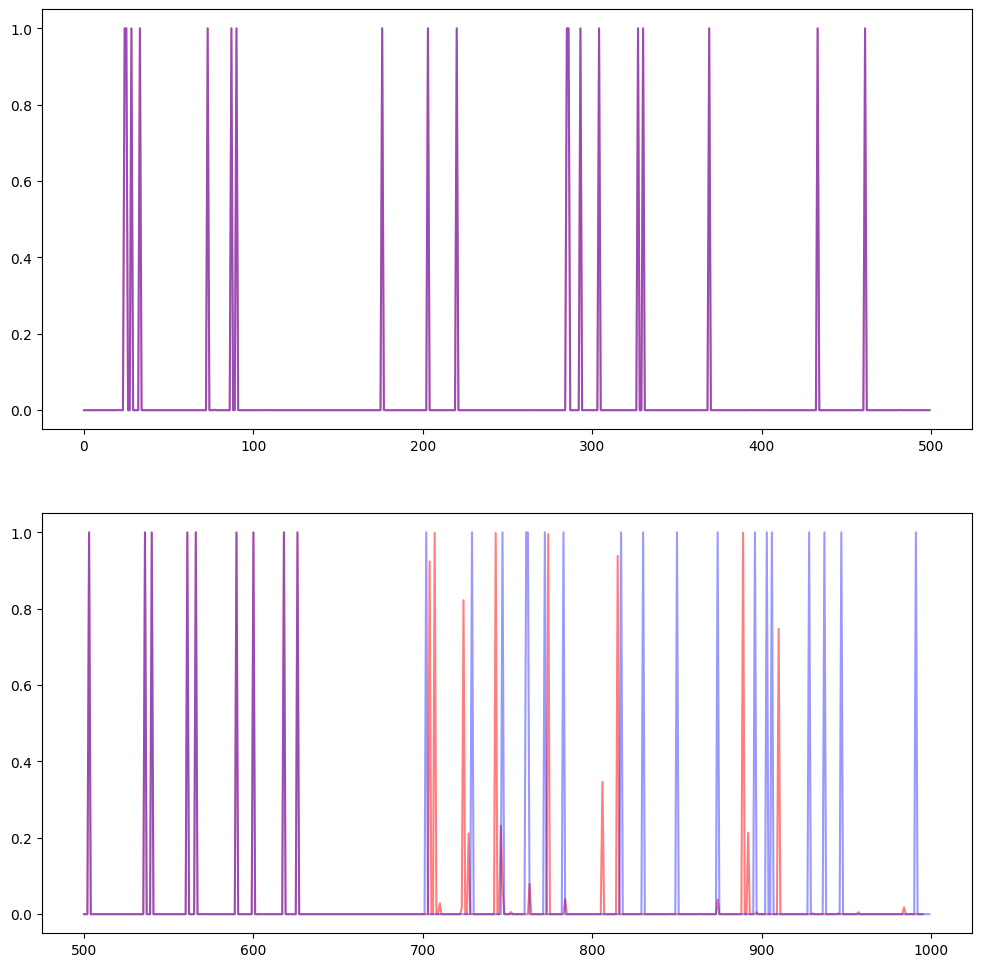

In [39]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
print(np.where(np.round(all_pred_result[:,0]) >=1.0)[0] - int(WINDOW_WIDTH//2))
fig, axs = plt.subplots(T//500, 1, figsize=(12, 12))
for subplot_row in range(T//500):
    axs[subplot_row].plot(
        np.arange(min(1000, len(all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500],
        c='red', alpha=0.5)
    axs[subplot_row].plot(
        np.arange(min(500, len(target_df['cps'][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        target_df['cps'][subplot_row*500: subplot_row*500 + 500],
        c='blue', alpha=0.4)

[     1     30     81 ...  99993  99999 100000]
[   -4    25    76 ... 99775 99778 99866]


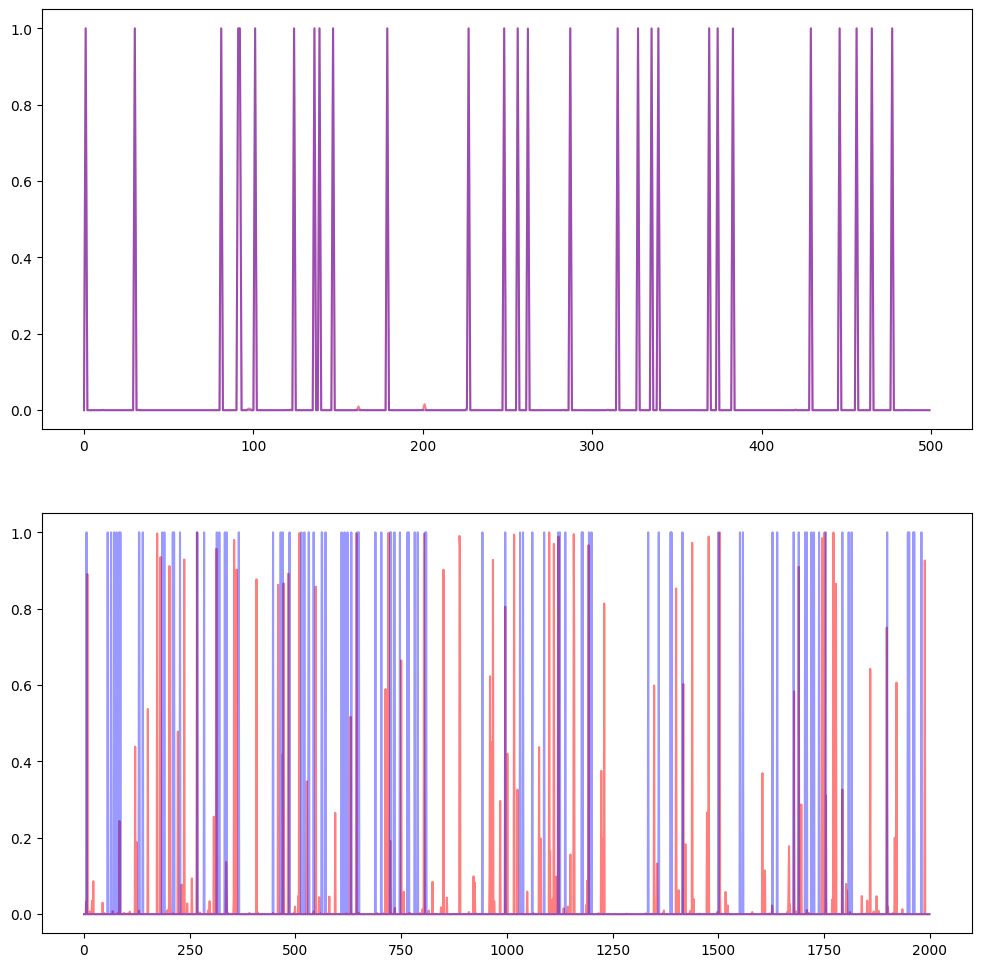

In [32]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
print(np.where(np.round(all_pred_result[:,0]) >=1.0)[0] - int(WINDOW_WIDTH//2))
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
axs[0].plot(
        np.arange(len(all_pred_result[:,0][:500])),
        all_pred_result[:,0][:500],
        c='red', alpha=0.5)
axs[0].plot(
        np.arange(len(all_pred_result[:,0][:500])),
        target_df['cps'][:500],
        c='blue', alpha=0.4)

axs[1].plot(
        np.arange(len(all_pred_result[:,0][int(T*0.7):int(T*0.7) + 2000])),
        all_pred_result[:,0][int(T*0.7):int(T*0.7) + 2000],
        c='red', alpha=0.5)
axs[1].plot(
        np.arange(len(all_pred_result[:,0][int(T*0.7):int(T*0.7) + 2000])),
        target_df['cps'][int(T*0.7):int(T*0.7) + 2000],
        c='blue', alpha=0.4)

In [ ]:
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,0], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,1], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['alphas'], c='blue')

In [25]:
trajectory_object = trajectory_list[12]
trajectory_label = label_list[12]
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)

xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]
xs -= xs[0]
ys -= ys[0]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3]

train_df = np.array([xs, ys, msd, diff_coefs, angles]).T
train_df = pd.DataFrame(train_df, columns=['xs', 'ys', 'msd', 'diff_coefs', 'angles'])
target_df = np.array([labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps]).T
target_df = pd.DataFrame(target_df, columns=['lb_diff_coefs', 'alphas', 'states', 'cps'])

test_ = make_prediction_set(train_df, WINDOW_WIDTH)
test_result = residual_lstm.predict(test_)

6/6 [==============================] - 1s 151ms/step


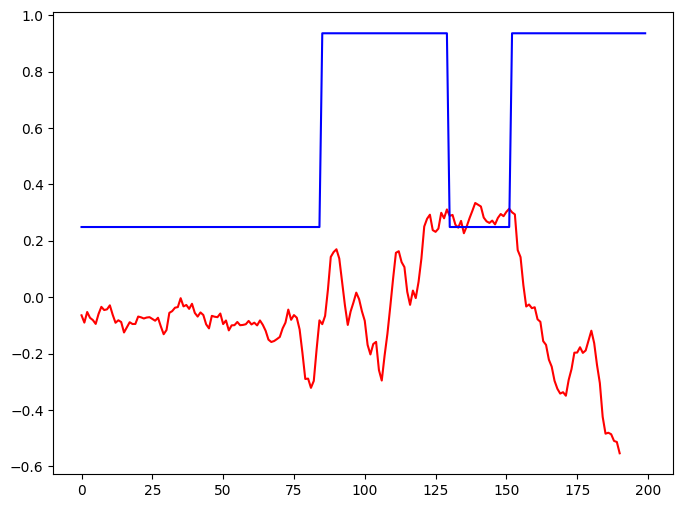

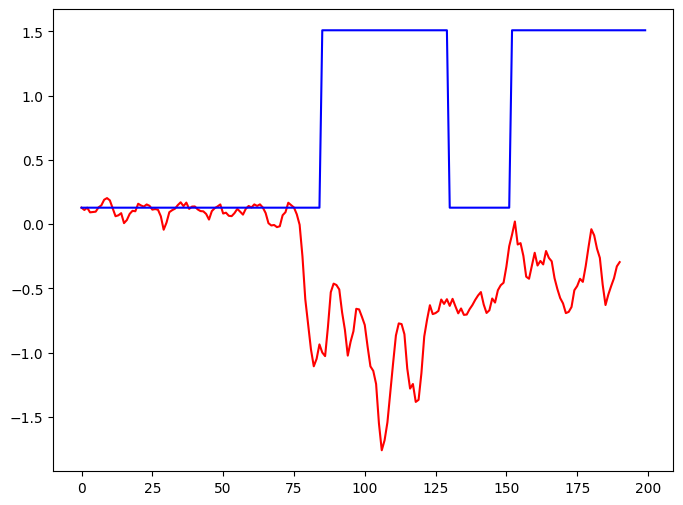

In [26]:
plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,0], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,1], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['alphas'], c='blue')